# Changelog

**01.12.22**
- Removed remark about every transaction having between 12 and 15 items, as I couldn't explain why (executed `dtf.isnull().values.any()` and the dataframe has no NaN values, this means every person contains all items, although they might be valued zero)
- Dropped `fnlwgt` from the dataframe
- Tried binning again using `pandas.cut()`, but results in the same binning limits as manually calculated before, so I removed this part
- Added analysis of top counts for the numerical variables
- Added analysis of `Sex - Female` to the end of the notebook

# Imports

In [156]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [157]:
with open("pyfim.py") as fp:
    exec(fp.read())
# from pyfim import *  # LOCALLY
# import urllib.request  # REMOTELY
# a = urllib.request.urlopen("https://members.loria.fr/EGalbrun/UEF_LPD/assignment/pyfim.py")
# exec(a.read())

# The Adult dataset

The `adult` dataset contains a mix of categorical and numerical attributes. The goal stated in its page, http://archive.ics.uci.edu/ml/datasets/Adult, is to predict whether a person makes over 50K a year or not.

Continuous attributes: `age`, `fnlwgt` (final weight), `education-num`, `capital-gain`, `capital-loss`, `hours-per-week`.

Categorical attributes: `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `native-country`. Furthermore, `yearly-salary` was added, as it is in the data but not specified by the database description.

Total of attributes: 15.

## Pre-processing

Let's first read and display the data and its outline.

In [158]:
cnames = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'yearly-salary'
    ]
dtf = pandas.read_csv('adult.data', sep=",", names=cnames, skipinitialspace=True)
dtf

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,yearly-salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


**01.12.22:** the `fnlwgt` attribute might have been used by the developed classifier mentioned in the website, and as such is not of interest to our analysis. Let's drop it from the dataframe.

In [159]:
dtf.drop(columns="fnlwgt")
cnames = [
    'age', 'workclass', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'yearly-salary'
    ]

A quick check for NaN values tells us there are none:

In [160]:
dtf.isnull().values.any()

False

Since this dataset contains both categorical and numerical attributes, we must prepare it for the FIM algorithm.

In [161]:
dcols = [] # to store the data columns corresponding to the new attributes
item_nbs = [] # to store the number of new attributes created from each original one (for plotting)
item_lbls = [] # to store labels corresponding to the new attributes

Let's first do the categorical attributes:

In [162]:
for var_name, var_cats in [
    ("workclass", ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked']),
    ("education", ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool']),
    ("marital-status", ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse']),
    ("occupation", ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces']),
    ("relationship", ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried']),
    ("race", ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black']),
    ("sex", ['Female', 'Male']),
    ("native-country", ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']),
    ('yearly-salary', ['<=50K', '>50K'])
]:
    cols = pandas.crosstab(dtf.index, [dtf[var_name]])  
    dcols.extend([cols[nc].values for nc in var_cats])
    item_nbs.append(len(var_cats))
    item_lbls.extend(["[%s - %s]" % (var_name, v) for v in var_cats])


    if var_name == 'native-country':
        native_cols = cols

native_cols

native-country,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In the table above, `?` appears in the column names for `native-country`. This might be an error in the dataset, or a missing country name.

Now, for the numerical attributes, we bin the values. The bin intervals for each attribute are defined as `(max - min)/5`. For `capital-gain`, the bins were chosen manually to avoid errors (empty bin).

In [163]:
numerical_attrb = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for attrb in numerical_attrb:
    min_value = dtf[attrb].min()
    max_value = dtf[attrb].max()
    step = (max_value-min_value)/5
    print(f"{attrb}: min {min_value} max {max_value} step {step}")

age: min 17 max 90 step 14.6
education-num: min 1 max 16 step 3.0
capital-gain: min 0 max 99999 step 19999.8
capital-loss: min 0 max 4356 step 871.2
hours-per-week: min 1 max 99 step 19.6


In [164]:
for var_name, var_bounds in [ 
    ("age", [31.6, 46.2, 60.8, 75.4]),
    ("education-num", [4, 7, 10, 13]),
    ("capital-gain", [25000, 50000]), #19999.8, 39999.6, 59999.4, 79999.2
    ("capital-loss", [871.2, 1742.4, 2613.6, 3484.8]),
    ("hours-per-week", [20.6, 40.2, 59.8, 79.4]),
]:
    bins = [dtf[var_name].min()]+var_bounds+[dtf[var_name].max()]
    bvs = numpy.arange(len(bins)-1)
    cols = pandas.crosstab(dtf.index, [pandas.cut(x=dtf[var_name], bins=bins, labels=bvs, include_lowest=True)])
    dcols.extend([cols[nc].values for nc in bvs])
    item_lbls.append("%s_..%s]" % (var_name, var_bounds[0]))
    item_nbs.append(len(var_bounds)+1)
    item_lbls.extend(["%s_(%s,%s]" % (var_name, var_bounds[i], var_bounds[i+1]) for i in range(len(var_bounds)-1)])
    item_lbls.append("%s_(%s.." % (var_name, var_bounds[-1]))

We can then obtain the binary matrix:

In [165]:
bin_mat = numpy.vstack(dcols).T  # https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
bin_mat[-1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

And turn it into a list of transactions for the FIM algorithm:

In [166]:
tracts = [frozenset(numpy.where(r)[0]) for r in bin_mat]
tracts[-1]

frozenset({2, 11, 24, 35, 45, 51, 56, 58, 100, 103, 108, 111, 114, 120})

## Statistics

In [167]:
len(tracts)

32561

There are `32561 transactions` in total. Each transaction corresponds to one person.

The histogram of the data shows the distribution accross categories for each person. The differences in amount inside of each attribute are evident:
- for the `age` attribute, the amount of younger people is much higher than older people (up to 31.6 years). A different binning could equalize the different bins, e.g. more bins in-between 18-30 years old;
- in the `workclass` attribute, `Federal-Gov` is the most common category;
- `Married-civ-spouse` is overwhelmingly higher in amount than other categories in the `marital-status` attribute.  

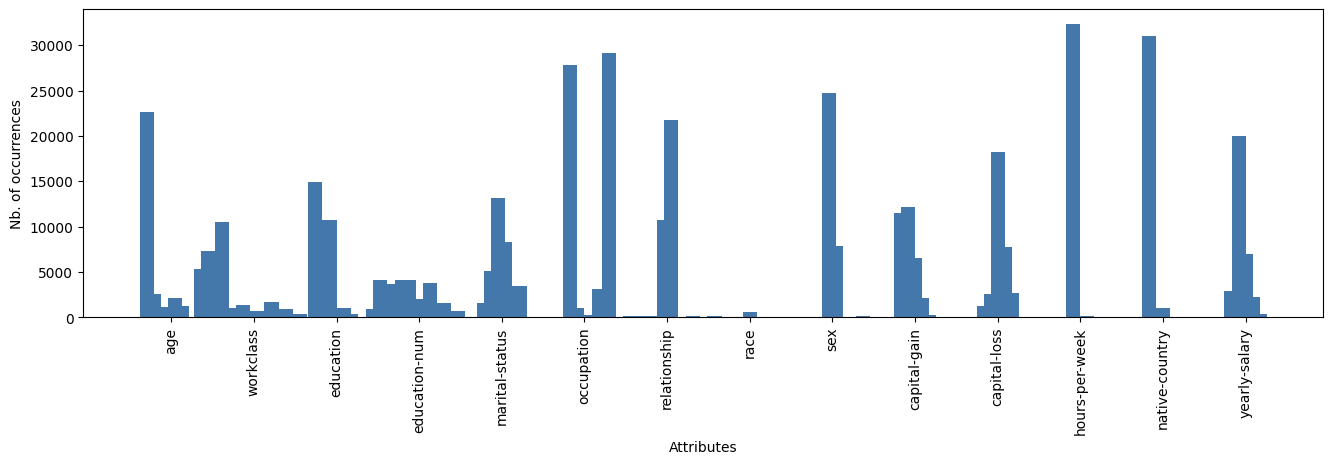

In [168]:
plt.figure(figsize=(16,4))
h = numpy.sum(bin_mat, axis=0)
bw = 3.5/numpy.max(item_nbs)
bf = 2
xbs = []
for ni, nb in enumerate(item_nbs):
    xbs.extend([ni+(n-0.5*(nb-1+bf))*bw for n in range(nb)])
plt.bar(xbs, h, width=bf*bw, align='edge', color=(68/255., 119/255., 170/255.))
plt.xticks(range(len(cnames)), cnames, rotation='vertical')
plt.xlabel("Attributes")
plt.ylabel("Nb. of occurrences")
plt.show()

**01.12.23:** Let's look into the counts in more detail.

In [169]:
var_counts = []

for var_name in [ 
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]:
    var_counts.append(dtf[var_name].value_counts().sort_values())
var_counts[2]

5060         1
7978         1
2387         1
1639         1
1455         1
         ...  
99999      159
7298       246
7688       284
15024      347
0        29849
Name: capital-gain, Length: 119, dtype: int64

**01.12.23:** Checking every numerical variable, we get the following counts:

- `age`: in the top 5 most frequent, we have mostly 31-36 y.o. people.
- `education-num`: education number `9`, `10` and `13` are the most frequent by a lot, with `9` being ahead by approx. 3k, and `13` being ahead by aprox. 3600. 
- `capital-gain`: a capital gain of `0` is the most frequent, with 29849 people. The second most frequent is `15024` with 347 people.
- `capital-loss`: same as with capital loss, `0` is the most frequent, with 31042. Second most frequent is `1902` with 202 people.
- `hours-per-week`: vast majority of people work `40 hours per week` (15217 people), with second place going to `50 hours per week` with 2819 people. There is one person who reported working `94 hours per week`.

## Mining

Running the FIM algorithm with a support threshold of 15% (0.15*435 ~ 65), we obtain the following:

In [170]:
nb_tot = len(tracts)
FI = fim(tracts, target='s', supp=15)
print("Found %d itemsets" % (len(FI)))

Found 2258 itemsets


The top 10 most frequent are:

In [171]:
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

capital-gain_..25000] (111,) 32346 0.993
capital-loss_..871.2] (114,) 31070 0.954
capital-loss_..871.2] capital-gain_..25000] (114, 111) 30855 0.948
[native-country - United-States] (58,) 29170 0.896
[native-country - United-States] capital-gain_..25000] (58, 111) 28977 0.890
[race - White] (51,) 27816 0.854
[native-country - United-States] capital-loss_..871.2] (58, 114) 27816 0.854
[race - White] capital-gain_..25000] (51, 111) 27625 0.848
[native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (58, 114, 111) 27623 0.848
[race - White] capital-loss_..871.2] (51, 114) 26492 0.814


The most frequent singleton is `capital-gain_..25000`, meaning that the most common characteristic for all people is their low income. An itemset with `native-country - United-States` also appears alongside the low income, showing that most low-income people are from this country (for this dataset). We also notice that most people in the dataset are `race - White`. 

Restricting the algorithm to itemsets of size 2 gives us the following top 10: 

In [172]:
FI = fim(tracts, target='s', supp=15, zmin=2)
print("Found %d itemsets\n" % (len(FI)))

print('')  # Space between prints

for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(" ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))

Found 2234 itemsets


capital-loss_..871.2] capital-gain_..25000] (114, 111) 30855 0.948
[native-country - United-States] capital-gain_..25000] (58, 111) 28977 0.890
[native-country - United-States] capital-loss_..871.2] (58, 114) 27816 0.854
[race - White] capital-gain_..25000] (51, 111) 27625 0.848
[native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (58, 114, 111) 27623 0.848
[race - White] capital-loss_..871.2] (51, 114) 26492 0.814
[race - White] capital-loss_..871.2] capital-gain_..25000] (51, 114, 111) 26301 0.808
[race - White] [native-country - United-States] (51, 58) 25621 0.787
[race - White] [native-country - United-States] capital-gain_..25000] (51, 58, 111) 25440 0.781
[yearly-salary - <=50K] capital-gain_..25000] (99, 111) 24713 0.759


The most frequent itemset of size 2 is a combination of `capital-loss_..871.2` with `capital-gain_..25000`. The meaning of capital loss was not clarified in the dataset page, but it is assumed that this combination might mean an association that people of low income also possess capital loss (perhaps debt?). 

Let's have a look at the most frequent maximal itemsets (15% supp. threshold).

In [173]:
FI = fim(tracts, target='m', supp=15, zmin=2)
print("Found %d itemsets" % (len(FI)))

i = 1
for fi in sorted(FI, key=lambda x: -x[1])[:10]:
    print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
    i += 1

Found 120 itemsets
1 [relationship - Husband] [workclass - Private] [native-country - United-States] [race - White] capital-loss_..871.2] capital-gain_..25000] [marital-status - Married-civ-spouse] [sex - Male] (47, 0, 58, 51, 114, 111, 24, 57) 6587 0.202
2 age_(31.6,46.2] [sex - Male] [race - White] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (102, 57, 51, 58, 114, 111) 6442 0.198
3 age_..31.6] [workclass - Private] [race - White] [native-country - United-States] [yearly-salary - <=50K] capital-loss_..871.2] capital-gain_..25000] (101, 0, 51, 58, 99, 114, 111) 6280 0.193
4 age_(31.6,46.2] [workclass - Private] [race - White] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (102, 0, 51, 58, 114, 111) 6223 0.191
5 age_(31.6,46.2] [yearly-salary - <=50K] [race - White] [native-country - United-States] capital-loss_..871.2] capital-gain_..25000] (102, 99, 51, 58, 114, 111) 5996 0.184
6 education-num_(10,13] [race - White] [nativ

The most common set of attributes a person has is a `white American male working privately with an yearly salary lower than 50K and capital gain lower than 25K, but also with capital loss lower than 871`. This maximal itemset has support count of `7018`, consisting `21.6%` of the maximal itemsets (for threshold 15%).

In the third position, we have a `white female American with same capital gain and loss as the male`, on a support count of `6090` (`18.7%` of the maximal itemsets).

What if we restrict the itemsets to include `yearly-salary - >50K` and check the profile of a person that receives over 50K a year? Reducing support threshold to 1%, targeting maximal itemsets, and setting the minimum itemset size to 5, we get the following top 10 itemsets:

In [174]:
FI = fim(tracts, target='m', supp=1, zmin=5)
print("Found %d itemsets\n" % (len(FI)))

class_labels = [100]
print_limit = 10
i = 1

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in class_labels for attr in fi[0]):  # Only look at itemsets including the Class attrb
        if i <= print_limit:
            print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 4270 itemsets

1 hours-per-week_(40.2,59.8] [yearly-salary - >50K] age_(31.6,46.2] [workclass - Private] [relationship - Husband] capital-loss_..871.2] [native-country - United-States] [race - White] capital-gain_..25000] [marital-status - Married-civ-spouse] [sex - Male] (121, 100, 102, 0, 47, 114, 58, 51, 111, 24, 57) 677 0.021
2 [yearly-salary - >50K] hours-per-week_(20.6,40.2] age_(31.6,46.2] [workclass - Private] [relationship - Husband] [race - White] capital-loss_..871.2] [native-country - United-States] capital-gain_..25000] [sex - Male] [marital-status - Married-civ-spouse] (100, 120, 102, 0, 47, 51, 114, 58, 111, 57, 24) 632 0.019
3 [education - Some-college] [yearly-salary - >50K] [workclass - Private] [relationship - Husband] [race - White] capital-loss_..871.2] [native-country - United-States] capital-gain_..25000] education-num_(7,10] [sex - Male] [marital-status - Married-civ-spouse] (9, 100, 0, 47, 51, 114, 58, 111, 108, 57, 24) 566 0.017
4 hours-per-week_(59.8,79

The top 2 itemsets are very similar: white American married male. For the top itemset, we see that people are overworked, with a value between `40.2` and `59.8` hours per week, aged between `31.6` and `46.2`.

The third most frequent itemset is different from the previous two in the sense that these people work a value between `20.6` and `40.2` hours per week. This may indicate that it is not necessary to overwork yourself with many hours a week to get a decent salary of 50K or more a year, although there seems to be an association with ages between `31.6` and `46.2`.

**01.12.23:** It's also worth noting that none of the top 10 include the attribute `sex - Female`. What about the top 100?

In [175]:
FI = fim(tracts, target='m', supp=1, zmin=5)
print("Found %d itemsets\n" % (len(FI)))

class_labels = [100]
print_limit = 100
i = 1

for fi in sorted(FI, key=lambda x: -x[1]):
    if any(attr in class_labels for attr in fi[0]):  # Only look at itemsets including the Class attrb
        if i <= print_limit:
            print(i, " ".join([item_lbls[x] for x in fi[0]]), fi[0], fi[1], "%.3f" % (fi[1]/nb_tot))
            i += 1

Found 4270 itemsets

1 hours-per-week_(40.2,59.8] [yearly-salary - >50K] age_(31.6,46.2] [workclass - Private] [relationship - Husband] capital-loss_..871.2] [native-country - United-States] [race - White] capital-gain_..25000] [marital-status - Married-civ-spouse] [sex - Male] (121, 100, 102, 0, 47, 114, 58, 51, 111, 24, 57) 677 0.021
2 [yearly-salary - >50K] hours-per-week_(20.6,40.2] age_(31.6,46.2] [workclass - Private] [relationship - Husband] [race - White] capital-loss_..871.2] [native-country - United-States] capital-gain_..25000] [sex - Male] [marital-status - Married-civ-spouse] (100, 120, 102, 0, 47, 51, 114, 58, 111, 57, 24) 632 0.019
3 [education - Some-college] [yearly-salary - >50K] [workclass - Private] [relationship - Husband] [race - White] capital-loss_..871.2] [native-country - United-States] capital-gain_..25000] education-num_(7,10] [sex - Male] [marital-status - Married-civ-spouse] (9, 100, 0, 47, 51, 114, 58, 111, 108, 57, 24) 566 0.017
4 hours-per-week_(59.8,79

**01.12.23:** Looking through the full output, we find two instances of `Sex - Female`:

- 12 [relationship - Wife] [yearly-salary - >50K] capital-gain_..5000] [race - White] capital-loss_..871.2] [native-country - United-States] [marital-status - Married-civ-spouse] [sex - Female] capital-gain_..25000] capital-loss_..871.2] (45, 100, 134, 51, 114, 58, 24, 56, 111, 137) 440 0.014
- 20 [yearly-salary - >50K] [sex - Female] [workclass - Private] capital-gain_..5000] [race - White] capital-loss_..871.2] [native-country - United-States] capital-gain_..25000] capital-loss_..871.2] (100, 56, 0, 134, 51, 114, 58, 111, 137) 420 0.013

Summing to a mere total of `860 females` in the top 100 most frequent itemsets with `yearly-salary - >50K`. This might indicate a disparity between the salary of males and females. Let's check the male vs female distribution:

In [179]:
dtf['sex'].value_counts().sort_values()

Female    10771
Male      21790
Name: sex, dtype: int64

**01.12.23:** Our dataset contains `67% male` and `33% female`. Although the distribution is strongly inclined towards the male size (much higher count of males in the dataset), it is still unusual that only 2 of the 100 most frequent itemsets containing `yearly-salary - >50K` include `Sex - Female`. It could also be the case that the itemsets are simply different, i.e. many of the males in the 67% are repeated accross the top 100 itemsets. The analysis would be more qualitative if sorted by uniqueness.